# Google Driveマウント

In [ ]:
from google.colab import drive
drive.mount('./gdrive')

# 必要パッケージインストール

In [ ]:
!pip install -U albumentations
!pip install segmentation-models.pytorch

# データセットダウンロード

In [ ]:
!git clone https://github.com/Kazuhito00/Skin-Clothes-Hair-Segmentation-using-SMP.git

In [ ]:
%cd Skin-Clothes-Hair-Segmentation-using-SMP

# 乱数シード固定

In [5]:
import os
import random

import torch
import numpy as np

def initialize_random_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
initialize_random_seed(42)

# データセットクラス作成

In [7]:
import os
import re
import glob

import numpy as np
from PIL import Image
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            target_classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        # ファイルパス一覧
        input_path = os.path.join(images_dir, '*')
        file_paths = [
            p for p in glob.glob(input_path)
            if re.search('/*\.(jpg|jpeg|png|gif|bmp)', str(p))
        ]

        # ファイル名一覧
        self.filenames  = [os.path.basename(file_path) for file_path in file_paths]
        
        # 画像/マスク画像ファイルパス一覧
        self.images_paths = [
            os.path.join(images_dir, filename) for filename in self.filenames
        ]
        self.masks_paths = [
            os.path.join(masks_dir, filename)  for filename in self.filenames
        ]

        # 使用するクラスID一覧
        self.class_ids = [classes.index(class_name.lower()) for class_name in target_classes]

        # データ拡張用/前処理用コールバック
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, index):
        # 画像
        image = Image.open(self.images_paths[index])
        image = np.array(image)

        # マスク画像
        mask_image = Image.open(self.masks_paths[index])
        mask = np.array(mask_image)
        masks = [(mask == v) for v in self.class_ids]
        mask = np.stack(masks, axis=-1).astype('float')

        # データ拡張実施
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # 前処理実施
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.filenames)

# 描画用関数

In [8]:
import matplotlib.pyplot as plt

def draw_images(**images):
    plt.figure(figsize=(16, 5))

    for index, (name, image) in enumerate(images.items()):
        plt.subplot(1, len(images), index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)

    plt.show()

# クラス設定

In [9]:
CLASSES = [
    'background', 
    'skin',
    'clothes', 
    'hair', 
]
TARGET_CLASSES = [
    'skin',
    'clothes', 
    'hair', 
]

# 学習データ確認

In [10]:
DATA_DIR = '01.dataset'

image_dir = os.path.join(DATA_DIR, 'image')
annotation_dir = os.path.join(DATA_DIR, 'annotation')

dataset = Dataset(
    image_dir, 
    annotation_dir, 
    classes=CLASSES,
    target_classes=TARGET_CLASSES,
)

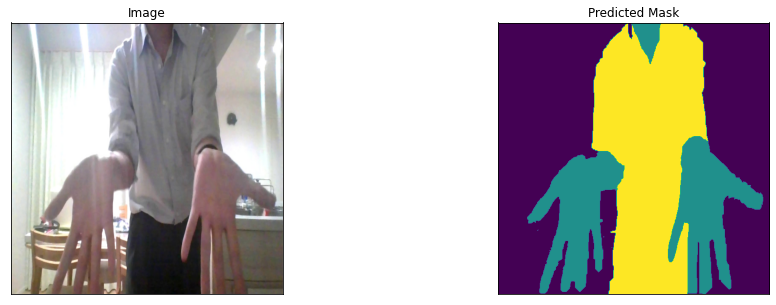

In [11]:
import copy 

# データ取得
image, masks = dataset[0]
masks = masks.transpose(2, 0, 1)

# マスク画像統合
debug_mask = copy.deepcopy(masks[0])
for index, mask in enumerate(masks):
    temp_mask = copy.deepcopy(mask)
    debug_mask = np.where((temp_mask == 0), debug_mask,
                            (index+1)).astype('uint8')

# 画像描画
draw_images(
    image=image,
    predicted_mask=debug_mask
)

# データ拡張準備

In [12]:
import albumentations as albu

# 学習データ用データ拡張
def get_training_augmentation():
    transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(contrast_limit=(-0.0, 0.0), p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=(-0.0, 0.0), p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(transform)


# 検証データ用データ拡張
def get_validation_augmentation():
    transform = []
    return albu.Compose(transform)


# 前処理
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(transform)

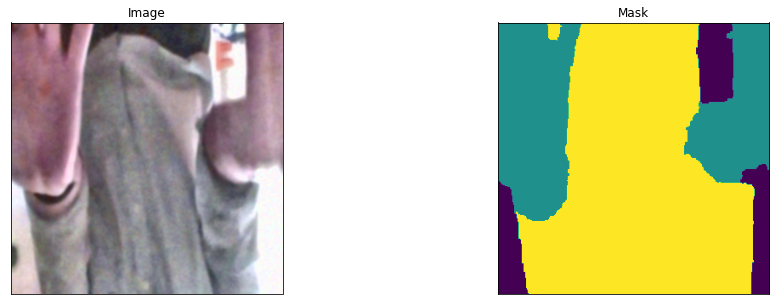

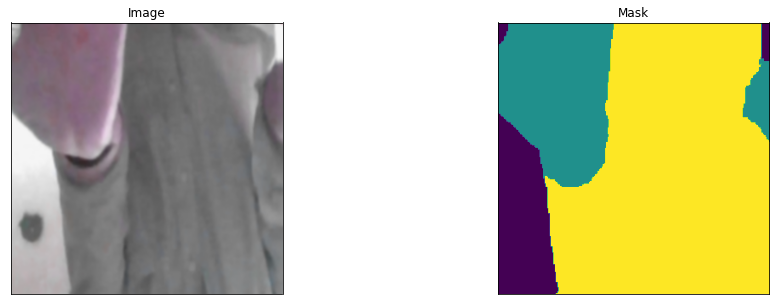

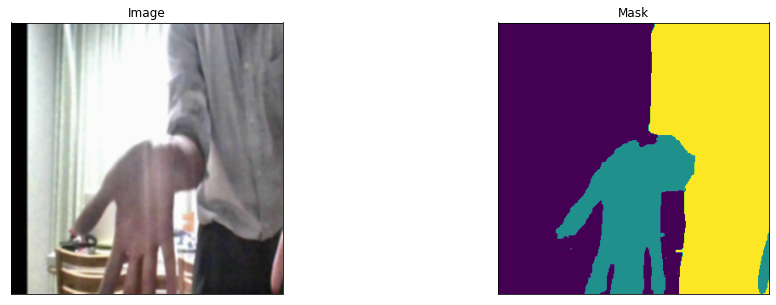

In [13]:
# データ拡張確認
augmented_dataset = Dataset(
    image_dir, 
    annotation_dir, 
    augmentation=get_training_augmentation(),
    classes=CLASSES,
    target_classes=TARGET_CLASSES,
)

for _ in range(3):
    image, masks = augmented_dataset[0]
    
    masks = masks.transpose(2, 0, 1)
    debug_mask = copy.deepcopy(masks[0])
    for index, mask in enumerate(masks):
        temp_mask = copy.deepcopy(mask)
        debug_mask = np.where((temp_mask == 0), debug_mask,
                                (index+1)).astype('uint8')

    draw_images(image=image, mask=debug_mask)

# モデル構築

In [14]:
import segmentation_models_pytorch as smp

# 参考：https://github.com/qubvel/segmentation_models.pytorch

# モデル定義リスト
model_list = [
    [smp.Unet         , 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid'],
    [smp.Unet         , 'timm-mobilenetv3_small_100',         'imagenet', 'sigmoid'],
    [smp.UnetPlusPlus , 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid'],
    [smp.UnetPlusPlus , 'timm-mobilenetv3_small_100',         'imagenet', 'sigmoid'],
    [smp.DeepLabV3Plus, 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid'],
    [smp.DeepLabV3Plus, 'timm-mobilenetv3_small_100',         'imagenet', 'sigmoid'],
    [smp.DeepLabV3Plus, 'timm-mobilenetv3_large_minimal_100', 'imagenet', 'sigmoid'],
    [smp.MAnet        , 'timm-tf_efficientnet_lite0',         'imagenet', 'sigmoid'],
    [smp.Linknet      , 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid'],
    [smp.PAN          , 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid'],
    [smp.PAN          , 'timm-mobilenetv3_small_100',         'imagenet', 'sigmoid'],
    [smp.PAN          , 'timm-mobilenetv3_large_minimal_100', 'imagenet', 'sigmoid'],
    [smp.PAN          , 'timm-mobilenetv3_large_075',         'imagenet', 'sigmoid'],
]

for index, model_info in enumerate(model_list):
    print(index, [model_info[0].__name__, *model_info[1:]])

0 ['Unet', 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid']
1 ['Unet', 'timm-mobilenetv3_small_100', 'imagenet', 'sigmoid']
2 ['UnetPlusPlus', 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid']
3 ['UnetPlusPlus', 'timm-mobilenetv3_small_100', 'imagenet', 'sigmoid']
4 ['DeepLabV3Plus', 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid']
5 ['DeepLabV3Plus', 'timm-mobilenetv3_small_100', 'imagenet', 'sigmoid']
6 ['DeepLabV3Plus', 'timm-mobilenetv3_large_minimal_100', 'imagenet', 'sigmoid']
7 ['MAnet', 'timm-tf_efficientnet_lite0', 'imagenet', 'sigmoid']
8 ['Linknet', 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid']
9 ['PAN', 'timm-mobilenetv3_small_minimal_100', 'imagenet', 'sigmoid']
10 ['PAN', 'timm-mobilenetv3_small_100', 'imagenet', 'sigmoid']
11 ['PAN', 'timm-mobilenetv3_large_minimal_100', 'imagenet', 'sigmoid']
12 ['PAN', 'timm-mobilenetv3_large_075', 'imagenet', 'sigmoid']


In [15]:
model_index = 5

In [16]:
# モデル構築
ENCODER = model_list[model_index][1]
ENCODER_WEIGHTS = model_list[model_index][2]
ACTIVATION = model_list[model_index][3]

model = model_list[model_index][0](
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(TARGET_CLASSES),
    activation=ACTIVATION,
)

# 前処理用関数取得
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth


  0%|          | 0.00/9.78M [00:00<?, ?B/s]

# torchinfoでモデル情報確認

In [17]:
!pip install torchinfo

In [18]:
from torchinfo import summary

In [19]:
model_statistics = summary(model, input_size=(1, 3, 512, 512))
model_statistics

Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Plus                                           --                        --
├─MobileNetV3Encoder: 1-1                               [1, 3, 512, 512]          --
│    └─MobileNetV3Features: 2                           --                        --
│    │    └─Conv2dSame: 3-1                             [1, 16, 256, 256]         432
│    │    └─BatchNorm2d: 3-2                            [1, 16, 256, 256]         32
│    │    └─Hardswish: 3-3                              [1, 16, 256, 256]         --
├─DeepLabV3PlusDecoder: 1-2                             [1, 256, 128, 128]        --
│    └─Sequential: 2-1                                  [1, 256, 32, 32]          --
│    │    └─ASPP: 3-4                                   [1, 256, 32, 32]          1,083,584
│    │    └─SeparableConv2d: 3-5                        [1, 256, 32, 32]          67,840
│    │    └─BatchNorm2d: 3-6                    

In [20]:
print(model_statistics.total_params)

2161651


# データローダー作成

In [21]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split

# データ格納パス
image_dir = os.path.join(DATA_DIR, 'image')
annotation_dir = os.path.join(DATA_DIR, 'annotation')

# データセット
dataset = Dataset(
    image_dir,
    annotation_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    target_classes=TARGET_CLASSES,
)

# 学習/検証データ分割
train_index, validation_index = train_test_split(range(len(dataset)), test_size=0.2)

train_dataset = Subset(dataset, train_index)
validation_dataset = Subset(dataset, validation_index)

# 学習/検証データローダー
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

print('Train Dataset Count:', len(train_dataset), ', Remainder:', len(train_dataset) % batch_size)
print('Validation Dataset Count:', len(validation_dataset))

Train Dataset Count: 5 , Remainder: 5
Validation Dataset Count: 2


# モデル訓練

In [22]:
# 最適化関数
lr = 0.001
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=lr),
])

# 損失関数
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# 学習/検証エポックランナー
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    verbose=True,
)

validation_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)

In [ ]:
# 訓練
epoch = 1000

lr_decay_check_count = 0
lr_decay_count = 0
es_check_count = 0

best_score = 0

for i in range(epoch):
    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_dataloader)
    valid_logs = validation_epoch.run(validation_dataloader)

    # ベストモデル保存
    if best_score < valid_logs['iou_score']:
        print(best_score, '->', valid_logs['iou_score'], 'Model saved')
        best_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')

        lr_decay_check_count = 0
        es_check_count = 0
    else:
        lr_decay_check_count += 1
        es_check_count += 1

    # 早期停止    
    if es_check_count >= 30:
        print('Early stopping')
        break

    # 学習率低減
    if lr_decay_check_count >= 10:
        lr_decay_count += 1

        optimizer.param_groups[0]['lr'] = lr / (5 * lr_decay_count)
        print('Learning rate decay')

        lr_decay_check_count = 0

print('Best Score(IoU):', best_score)

# PyTorch推論確認

In [24]:
# 訓練済みモデルロード
model = torch.load('./best_model.pth')

In [25]:
import cv2  

# データ読み込み
image = cv2.imread('/content/Skin-Clothes-Hair-Segmentation-using-SMP/01.dataset/image/0.png')

# リサイズ・RGB変換
image = cv2.resize(image, (512, 512))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 標準化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = (image / 255 - mean) / std

# HWC → CHW
x = x.transpose(2, 0, 1).astype('float32')  

In [26]:
%%time
# 推論
x_tensor = torch.from_numpy(x).unsqueeze(0)
result = model.predict(x_tensor)
# result = (result.squeeze().cpu().numpy().round())
result = (result.squeeze().cpu().numpy())
result = np.where(result > 0.5, 1, 0)

CPU times: user 299 ms, sys: 5.93 ms, total: 305 ms
Wall time: 158 ms


skin


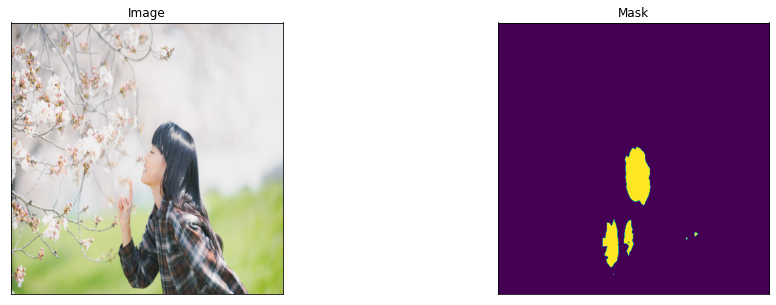

clothes


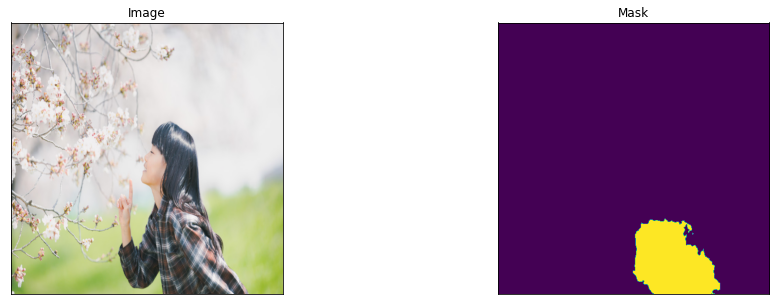

hair


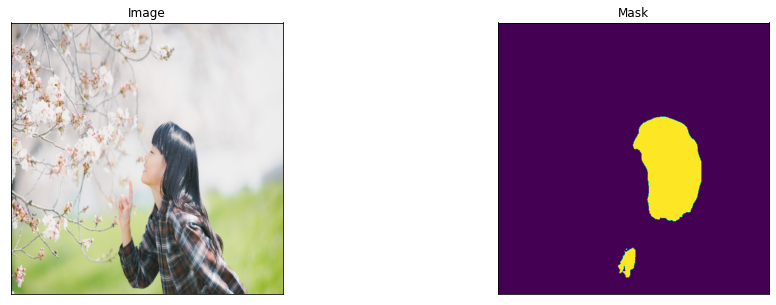

In [27]:
# 各クラス毎の結果描画
if len(TARGET_CLASSES) > 1:
    for index, mask in enumerate(result):
        print(TARGET_CLASSES[index])
        draw_images(
            image=image,
            mask=mask
        )
else:
    print(TARGET_CLASSES[0])
    draw_images(
        image=image,
        mask=result
    )

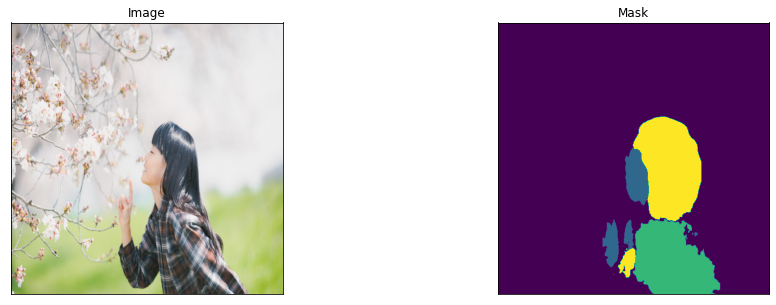

In [28]:
import copy 

if len(TARGET_CLASSES) > 1:
    # クラス毎のマスク画像を統合
    debug_mask = copy.deepcopy(result[0])
    for index, mask in enumerate(result):
        temp_mask = copy.deepcopy(mask)
        debug_mask = np.where((temp_mask == 0), debug_mask,
                                (index+1)).astype('uint8')

    draw_images(
        image=image,
        mask=debug_mask
    )

# ONNX変換

In [30]:
model = torch.load('./best_model.pth')

model.eval()

torch.onnx.export(
    model, 
    x_tensor, 
    'best_model.onnx', 
    opset_version=13, 
)

/usr/local/lib/python3.7/dist-packages/timm/models/layers/padding.py:19: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)
/usr/local/lib/python3.7/dist-packages/timm/models/layers/padding.py:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)
/usr/local/lib/python3.7/dist-packages/timm/models/layers/padding.py:31: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data fl

In [31]:
!pip install onnx-simplifier

     |████████████████████████████████| 12.3 MB 5.2 MB/s 
     |████████████████████████████████| 466 kB 88.4 MB/s 
     |████████████████████████████████| 4.5 MB 79.7 MB/s 
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.6-py3-none-any.whl size=12873 sha256=30c09d82c4287914f43bc33f9f8a5233fa8e724b95c7f63517e409184f362b2b
  Stored in directory: /root/.cache/pip/wheels/0c/47/80/8eb21098e22c19d60b1c14021ee67442b4ad2d7991fdad46ba
Successfully built onnx-simplifier


In [32]:
!python -m onnxsim best_model.onnx best_model_simplifier.onnx

Simplifying...
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


# ONNX推論確認

In [33]:
# パッケージインストール
!pip install onnxruntime
# !pip install onnxruntime-gpu

In [34]:
# モデル読み込み
import onnxruntime

print(onnxruntime.get_device())
onnx_session = onnxruntime.InferenceSession('best_model_simplifier.onnx')

CPU


In [35]:
# 入力/出力詳細
input_detail = onnx_session.get_inputs()
output_detail = onnx_session.get_outputs()

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

print('input_detail: ', input_detail[0])
print('output_detail: ', output_detail[0])

input_detail:  NodeArg(name='x.1', type='tensor(float)', shape=[1, 3, 512, 512])
output_detail:  NodeArg(name='1091', type='tensor(float)', shape=[1, 3, 512, 512])


In [36]:
import cv2

# データ読み込み
image = cv2.imread('/content/Skin-Clothes-Hair-Segmentation-using-SMP/01.dataset/image/0.png')

# リサイズ・RGB変換
image = cv2.resize(image, (512, 512))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 標準化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = (image / 255 - mean) / std

# HWC → CHW
x = x.transpose(2, 0, 1).astype('float32')  

# (1, 3, Height, Width)形式へリシェイプ
x = x.reshape(-1, 3, 512, 512)

In [37]:
%%time
# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})
onnx_result = np.array(onnx_result).squeeze()
onnx_result = (onnx_result.round())

CPU times: user 241 ms, sys: 13.9 ms, total: 255 ms
Wall time: 128 ms


skin


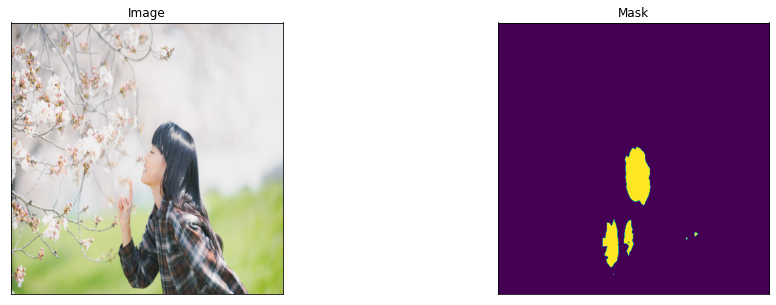

clothes


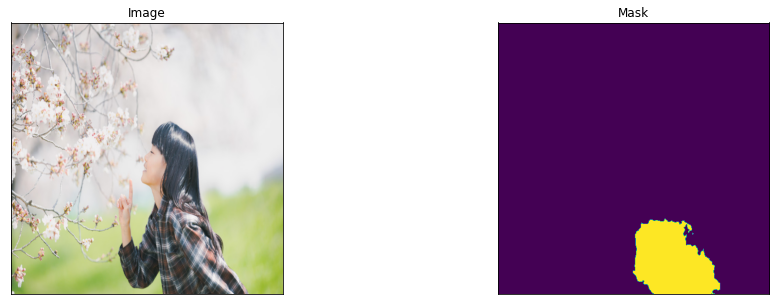

hair


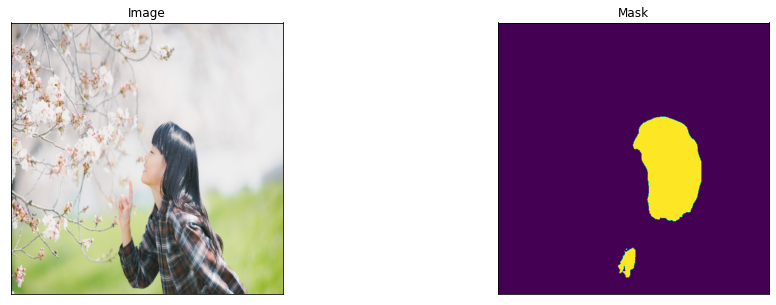

In [38]:
# 各クラス毎の結果描画
if len(TARGET_CLASSES) > 1:
    for index, mask in enumerate(onnx_result):
        print(TARGET_CLASSES[index])
        draw_images(
            image=image,
            mask=mask
        )
else:
    print(TARGET_CLASSES[0])
    draw_images(
        image=image,
        mask=onnx_result
    )

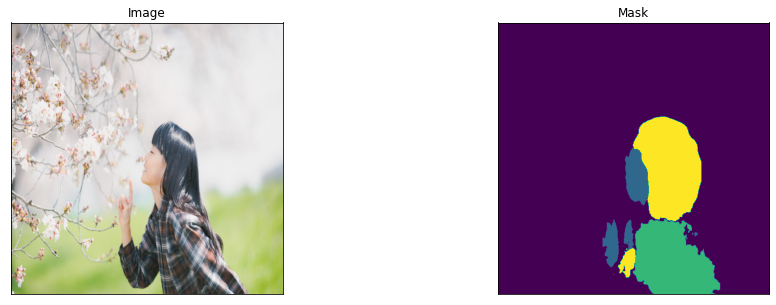

In [39]:
import copy 

if len(TARGET_CLASSES) > 1:
    # クラス毎のマスク画像を統合
    debug_mask = copy.deepcopy(onnx_result[0])
    for index, mask in enumerate(onnx_result):
        temp_mask = copy.deepcopy(mask)
        debug_mask = np.where((temp_mask == 0), debug_mask,
                                (index+1)).astype('uint8')

    draw_images(
        image=image,
        mask=debug_mask
    )

# モデルをGoogle Driveに保存

In [45]:
# モデル保存先ディレクトリ名
save_directory_name = model_list[model_index][0].__name__
save_directory_name += '\(' + model_list[model_index][1] + '\)'
save_directory_name += '_' + str(len(dataset))
save_directory_name += '_' + str(round(model_statistics.total_params / 1000000, 2)) + 'M'
save_directory_name += '_' + str(round(best_score, 4))

print(save_directory_name)

DeepLabV3Plus\(timm-mobilenetv3_small_100\)_7_2.16M_0.8814


In [46]:
# Google Driveに保存
!mkdir -p '/content/gdrive/MyDrive/SemanticSegmentation/'`date '+%Y%m%d/'`$save_directory_name

!cp best_model.pth '/content/gdrive/MyDrive/SemanticSegmentation/'`date '+%Y%m%d/'`$save_directory_name
!cp best_model.onnx '/content/gdrive/MyDrive/SemanticSegmentation/'`date '+%Y%m%d/'`$save_directory_name
!cp best_model_simplifier.onnx '/content/gdrive/MyDrive/SemanticSegmentation/'`date '+%Y%m%d/'`$save_directory_name

In [ ]:
# zip圧縮しディレクトリをダウンロードする
!zip -rj '/content/'$save_directory_name'.zip' '/content/gdrive/MyDrive/SemanticSegmentation/'`date '+%Y%m%d/'`$save_directory_name

from google.colab import files
files.download('/content/' + save_directory_name.replace('\\', '') + '.zip')